In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import joblib
from utils.func import timer
from eda.auto_credit_stagetary import AutoCreditStrategy
from model.auto_model_classify import AutoMachineLearning

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# TODO:基础数据sql读取

* 非标准化流程：1.查看X变量的类型分布；2.查看X变量的取值空间分布；3.查看Y标签的值映射关系。TODO：配置空值标识、明确连续变量和离散变量。
* 进入自动化信贷策略的标准流程：

    描述性统计、分箱及IV计算。
    挑选信息量大、可解释性强、风险区分能力强、时间上稳定的X变量，根据风险倍数确定阈值，输出单维度策略。
    挑选具有风险识别能力、可解释性欠佳的变量，通过决策树构造多维度策略，输出gini值0.32以下（对应bad_rate大于80%）、样本数量较多的叶子节点，输出组合规则。

In [4]:
# # base_data = pd.read_pickle('./data/input/base_data.pkl')
# base_data = pd.read_csv('./data/input/german.csv',delim_whitespace = True)

# print(base_data.shape)
# columns = ['status_account','duration','credit_history','purpose', 'amount',
#             'svaing_account', 'present_emp', 'income_rate', 'personal_status',
#             'other_debtors', 'residence_info', 'property', 'age',
#             'inst_plans', 'housing', 'num_credits',
#             'job', 'dependents', 'telephone', 'foreign_worker', 'target']
# base_data.columns = columns
# base_data['id'] = range(base_data.shape[0])
# base_data['target'] -= 1
# features = columns[:-1]

In [5]:
base_data = pd.read_csv('./data/input/wpqx_dq_variables.csv')
del base_data['Unnamed: 0']
cols = [i.split('.')[1] for i in base_data.columns]
base_data.columns = cols
print(base_data.columns[:30])
base_data['data_date'] = base_data['create_date'].apply(lambda x:x[:7])

Index(['product_no', 'create_date', 'apply_id', 'id_number', 'md5_mobile',
       'decision_code', '分流', 'creditline', 'loanrate', 'randomflag',
       'due_fpd5', 'due_fpd10', 'due_fpd15', 'due_mob2', 'due_mob3',
       'due_mob6', 'due_mob12', 'def_fpd5', 'def_fpd10', 'def_fpd15',
       'def_mob2_30', 'def_mob3_30', 'def_mob6_30', 'def_mob12_30',
       'br_m1_cell_nbank_oth_allnum', 'br_m6_id_nbank_ca_orgnum',
       'br_als_m6_id_nbank_oth_orgnum', 'br_m6_cell_nbank_allnum',
       'br_als_m12_id_nbank_p2p_orgnum', 'br_m3_id_nbank_max_monnum'],
      dtype='object')


In [6]:
base_data = base_data[(base_data['due_fpd10']==1)&(base_data['create_date']>'2021-09-30')] # 'due_fpd10'表现期，‘def_fpd10’好坏标签。

##### 资产分析
1. 按自然日期分段，拉通运营、风险和客群资质的监控：授信申请/通过规模、通过率、件均、额度、利率、TN用信率(活跃度*通过率=用信率)、用信通过率、TN额度使用率、期限、借款件均、借款利率、fpd、mob3_30、c_m1、授信模型分/多头/负债/三方逾期。
2. 不同细分客群下，按自然日期分段，拉通运营、风险和客群资质的监控。

基础数据加工逻辑：

1. 授信+借款粒度：授信时间、授信通过标识、额度、利率、用信通过标识、用信时间、借款金额、利率、期限、关联到借据的due_fpd/def_fpd、关联到授信的模型分/多头/负债/三方逾期、关联到客户的分客群标签性别/渠道、关联到授信的分客群标签车贷/房贷/有无信用卡、关联到借据的分客群标签首复借T+N。
2. 额度使用率:授信后N天内的支用金额/授信金额，从授信时间开始看，按照授信apply_id关联借据。借据粒度。根据用信日期和授信日期给每笔借据打标T0_flag/T3_flag/T7_flag/T15_flag/T30_flag/T60_flag/T90_flag。根据授信日期和当前日期给每个授信打标due_T0/due_T3/due_T7/due_T7/due_T15/due_T30/...。
3. 将借据粒度归结到授信粒度：一个授信可能存在若干借据，TN打标进行max归结(只要有一笔符合条件就算)。TN余额进行sum归结。
4. 计算授信客户从授信日期开始，截止到每一天的累计借款金额，从而计算支用金额/授信金额。
5. 计算授信客户从授信日期开始，截止到每一天的累计借款余额(借款金额-已还款金额)，从而计算借款余额/授信金额。

In [7]:
def apply_desc_stats(df):
    """
    资产分析，非策略分析。
    整体拉通统计或者分客群拉通统计:授信、用信、转化、额度使用、风险、资质。
    """
    row = {}
    # 授信
    row['apply_cnt'] = df.shape[0]
    row['pass_cnt'] = df[df['decision_code']==1].shape[0]
    row['pass_rate'] = round(row['pass_cnt']/row['apply_cnt'],4)
    row['avg_creditline'] = round(df[df['decision_code']==1]['creditline'].mean(),0)
    row['max_creditline'] = df['creditline'].max()
    row['min_creditline'] = df['creditline'].min()
    row['avg_rate'] = round(df[df['decision_code']==1]['loanrate'].mean(),4)
    
    # 用信及转化
    # 风险
    row['loan_cnt'] = df[df['due_fpd5']==1].shape[0]
    row['fpd10_due_cnt'] = df[df['due_fpd10']==1].shape[0]
    row['fpd10_bad'] = np.sum(df['def_fpd10'])
    row['fpd10_bad_rate'] = row['fpd10_bad']/row['fpd10_due_cnt']
    row['mob2_due_cnt'] = df[df['due_mob2']==1].shape[0]
    row['mob2_bad'] = np.sum(df['def_mob2_30'])
    row['mob2_bad_rate'] = row['mob2_bad']/row['mob2_due_cnt']
    
    # 资质-可解释变量
    for k in tell_cols.keys():
        row[k] = round(df[k].mean(),2)

    return pd.Series(row)

tell_cols = {
    'br_als_d7_id_nbank_allnum':'近7天非银申请次数',
    'br_als_d15_id_nbank_allnum':'近15天非银申请次数',
    'br_als_m1_id_nbank_allnum':'近1月非银申请次数',
    'br_als_m3_id_nbank_allnum':'近3月非银申请次数',
    'br_als_m6_id_nbank_allnum':'近6月非银申请次数',
    'br_als_m12_id_nbank_allnum':'近12月非银申请次数',

    'br_als_m1_id_bank_allnum':'近1月银行申请次数',
    'br_als_m3_id_bank_allnum':'近3月银行申请次数',
    'br_als_m6_id_bank_allnum':'近6月银行申请次数',
    'br_als_m12_id_bank_allnum':'近12月银行申请次数',

    # '人行授信总额(贷款+贷记卡)','本月应还款总额(贷款+贷记卡)','人行征信最长逾期月数(贷款+贷记卡)','人行征信当前逾期金额(贷款+贷记卡)'
    # 未结清贷款笔数
    # 未结清在贷余额
    }

base_data[list(tell_cols.keys())] = base_data[tell_cols.keys()].replace(-999, np.nan)
date_split_df = base_data[base_data['data_date']>'2021-09'].groupby('data_date').apply(apply_desc_stats)
date_split_df

,apply_cnt,pass_cnt,pass_rate,avg_creditline,max_creditline,min_creditline,avg_rate,loan_cnt,fpd10_due_cnt,fpd10_bad,...,br_als_d7_id_nbank_allnum,br_als_d15_id_nbank_allnum,br_als_m1_id_nbank_allnum,br_als_m3_id_nbank_allnum,br_als_m6_id_nbank_allnum,br_als_m12_id_nbank_allnum,br_als_m1_id_bank_allnum,br_als_m3_id_bank_allnum,br_als_m6_id_bank_allnum,br_als_m12_id_bank_allnum
data_date,,,,,,,,,,,,,,,,,,,,,
2021-10,34.0,34.0,1.0,12662.0,30000.0,1000.0,0.2117,34.0,34.0,0.0,...,1.40,1.75,2.32,5.50,8.52,11.25,2.25,2.08,2.35,2.56
2021-11,139.0,139.0,1.0,9648.0,30000.0,1000.0,0.2181,139.0,139.0,0.0,...,1.20,1.36,2.18,4.60,7.65,11.97,1.50,1.97,2.38,3.96
2021-12,207.0,207.0,1.0,12488.0,40000.0,1000.0,0.2238,207.0,207.0,0.0,...,1.40,1.66,2.27,4.16,7.11,11.17,1.57,2.16,2.47,3.54
2022-01,548.0,548.0,1.0,12560.0,40000.0,1000.0,0.2307,548.0,548.0,4.0,...,1.59,1.90,2.55,4.60,7.03,10.93,1.43,2.29,2.91,3.88
2022-02,708.0,708.0,1.0,13079.0,50000.0,1000.0,0.2325,708.0,708.0,8.0,...,1.49,1.97,2.74,5.85,9.87,16.70,1.32,2.31,3.40,4.79
2022-03,2218.0,2218.0,1.0,14100.0,50000.0,1000.0,0.2332,2218.0,2218.0,20.0,...,1.55,2.11,3.45,7.95,13.96,23.43,1.49,2.73,4.84,7.62
2022-04,1789.0,1789.0,1.0,18198.0,50000.0,3000.0,0.2316,1789.0,1789.0,16.0,...,1.51,2.01,3.17,7.25,12.65,20.69,1.48,2.46,4.46,6.73
2022-05,264.0,264.0,1.0,16712.0,50000.0,3000.0,0.2323,264.0,264.0,2.0,...,1.49,2.00,3.17,7.48,13.42,22.99,1.42,2.55,4.67,7.65


In [8]:
base_data['line_bin'] = pd.cut(base_data['creditline'],[500, 5000, 10000, 20000, 30000, 40000, 50000])
base_data[base_data['data_date']>'2021-09'].groupby('line_bin').apply(apply_desc_stats)

,apply_cnt,pass_cnt,pass_rate,avg_creditline,max_creditline,min_creditline,avg_rate,loan_cnt,fpd10_due_cnt,fpd10_bad,...,br_als_d7_id_nbank_allnum,br_als_d15_id_nbank_allnum,br_als_m1_id_nbank_allnum,br_als_m3_id_nbank_allnum,br_als_m6_id_nbank_allnum,br_als_m12_id_nbank_allnum,br_als_m1_id_bank_allnum,br_als_m3_id_bank_allnum,br_als_m6_id_bank_allnum,br_als_m12_id_bank_allnum
line_bin,,,,,,,,,,,,,,,,,,,,,
"(500, 5000]",2055.0,2055.0,1.0,3340.0,5000.0,1000.0,0.2350,2055.0,2055.0,22.0,...,1.68,2.30,3.75,8.81,15.80,26.70,1.46,2.60,4.48,7.03
"(5000, 10000]",1036.0,1036.0,1.0,7824.0,10000.0,5300.0,0.2341,1036.0,1036.0,7.0,...,1.47,1.91,3.04,6.87,11.62,19.55,1.49,2.50,4.17,6.42
"(10000, 20000]",1359.0,1359.0,1.0,14164.0,20000.0,10600.0,0.2327,1359.0,1359.0,7.0,...,1.42,1.91,3.05,6.86,11.76,19.28,1.48,2.66,4.57,6.91
"(20000, 30000]",500.0,500.0,1.0,25470.0,30000.0,21000.0,0.2293,500.0,500.0,4.0,...,1.35,1.69,2.22,4.56,7.43,12.01,1.58,2.41,3.93,5.63
"(30000, 40000]",373.0,373.0,1.0,36256.0,40000.0,31000.0,0.2228,373.0,373.0,4.0,...,1.29,1.48,2.03,3.73,6.04,9.34,1.37,2.14,3.20,4.49
"(40000, 50000]",584.0,584.0,1.0,48396.0,50000.0,41000.0,0.2200,584.0,584.0,6.0,...,1.19,1.40,1.78,3.56,5.99,9.44,1.40,2.12,3.59,5.08


In [9]:
base_data[base_data['data_date']>'2021-09'].groupby('loanrate').apply(apply_desc_stats)

,apply_cnt,pass_cnt,pass_rate,avg_creditline,max_creditline,min_creditline,avg_rate,loan_cnt,fpd10_due_cnt,fpd10_bad,...,br_als_d7_id_nbank_allnum,br_als_d15_id_nbank_allnum,br_als_m1_id_nbank_allnum,br_als_m3_id_nbank_allnum,br_als_m6_id_nbank_allnum,br_als_m12_id_nbank_allnum,br_als_m1_id_bank_allnum,br_als_m3_id_bank_allnum,br_als_m6_id_bank_allnum,br_als_m12_id_bank_allnum
loanrate,,,,,,,,,,,,,,,,,,,,,
0.1800,58.0,58.0,1.0,43331.0,50000.0,12000.0,0.1800,58.0,58.0,0.0,...,1.12,1.12,1.29,2.97,4.79,6.85,1.33,2.08,3.00,4.12
0.1980,156.0,156.0,1.0,39338.0,50000.0,3000.0,0.1980,156.0,156.0,0.0,...,1.19,1.20,1.52,2.65,4.55,6.75,1.46,2.06,3.17,4.44
0.2196,985.0,985.0,1.0,26824.0,50000.0,1000.0,0.2196,985.0,985.0,10.0,...,1.33,1.62,2.33,4.62,7.43,11.99,1.37,2.13,3.37,4.88
0.2358,4708.0,4708.0,1.0,11400.0,50000.0,1000.0,0.2358,4708.0,4708.0,40.0,...,1.55,2.09,3.29,7.48,13.06,21.79,1.48,2.59,4.44,6.81


In [10]:
features = cols[24:]
base_data.rename(columns={'def_fpd10':'target'}, inplace=True)
base_data['id'] = range(base_data.shape[0])
columns = ['id','target']+features
print(columns[:30])
print(base_data[columns].shape)

['id', 'target', 'br_m1_cell_nbank_oth_allnum', 'br_m6_id_nbank_ca_orgnum', 'br_als_m6_id_nbank_oth_orgnum', 'br_m6_cell_nbank_allnum', 'br_als_m12_id_nbank_p2p_orgnum', 'br_m3_id_nbank_max_monnum', 'br_apply15d_cell_orgnum', 'br_alm_m1_id_nbank_mc_allnum', 'br_apply12m_id_cnt', 'br_m6_id_nbank_max_monnum', 'br_apply12m_cell_orgnum', 'br_apply3m_id_cnt', 'br_apply12m_cell_cnt', 'br_apply1m_cell_orgnum', 'br_apply3m_cell_orgnum', 'br_m3_id_bank_orgnum', 'br_d7_bank_allnum_sca', 'br_als_m6_id_nbank_p2p_orgnum', 'br_m3_id_nbank_cf_orgnum', 'br_als_d7_id_nbank_p2p_orgnum', 'br_als_m12_id_nbank_p2p_allnum', 'br_als_m1_id_nbank_allnum', 'br_d7_nbank_ca_allnum_sca', 'br_als_m3_id_nbank_allnum', 'br_d7_id_bank_week_allnum_sca', 'br_m3_cell_avg_monnum', 'br_m6_id_bank_orgnum', 'br_apply6m_cell_cnt']
(5907, 2110)


In [11]:
features.remove('br_applyloanstr_createdate_onlycache')

In [12]:
to_dir = './data/output/wpqx/'
# auto_cs = AutoCreditStrategy(base_data[columns],id='id',features=features,target='target',if_reduce_mem=True)
auto_cs = AutoCreditStrategy(base_data[columns],id='id',features=features,target='target')
with timer('preprocess data'):
    auto_cs.preprocess()
auto_cs.desc_by_dataframe()  
# auto_cs.desc_statis.to_excel(to_dir+'desc_statis_新客.xlsx')
# auto_cs._feat_filter_by_desc()
auto_cs.bins_by_dataframe()
# auto_cs.total_woe_df.to_excel(to_dir+'bin_bad_rate_新客.xlsx')
single_rules = auto_cs.generate_single_rules()
# single_rules

preprocess data - done in 25s


In [13]:
single_rules

,index,feature,bin,total,bad,bad_rate,lift,woe,iv
42,0,br_apply12m_id_cnt,"(0.999, 2.0]",313,8,0.025559,3.019553,-1.122500,0.121146
43,1,br_apply12m_id_cnt,"(2.0, 4.0]",303,1,0.003300,0.389901,0.947057,0.029891
44,2,br_apply12m_id_cnt,"(4.0, 6.0]",248,3,0.012097,1.429113,-0.360724,0.006554
45,3,br_apply12m_id_cnt,"(6.0, 8.0]",269,4,0.014870,1.756729,-0.569934,0.019808
46,4,br_apply12m_id_cnt,"(8.0, 9.0]",135,0,0.000000,0.000000,7.742807,0.178389
...,...,...,...,...,...,...,...,...,...
11662,7,jg_cts_lbs_037,"(0.0588, 0.0871]",34,0,0.000000,0.000000,6.363893,0.036879
11663,8,jg_cts_lbs_037,"(0.0871, 0.149]",34,0,0.000000,0.000000,6.363893,0.036879
11664,9,jg_cts_lbs_037,"(0.149, 0.287]",35,0,0.000000,0.000000,6.392881,0.038138
11665,10,jg_cts_lbs_037,"(0.287, 0.5]",37,1,0.027027,3.192973,-1.179851,0.016345


In [15]:
single_rules.to_excel(to_dir+'single_rules_新客.xlsx',index=False)

In [16]:
auto_cs.total_woe_df[auto_cs.total_woe_df['feature']=='bj_tz_app_delta_ratio_m1_m12']

,index,feature,bin,total,bad,bad_rate,lift,woe,iv
2141,0,bj_tz_app_delta_ratio_m1_m12,"(0.009000000000000001, 0.04]",19,1,0.052632,6.217895,-1.872998,0.031704
2142,1,bj_tz_app_delta_ratio_m1_m12,"(0.04, 0.105]",16,0,0.000000,0.000000,5.610121,0.015269
2143,2,bj_tz_app_delta_ratio_m1_m12,"(0.105, 0.16]",21,1,0.047619,5.625714,-1.767638,0.029317
2144,3,bj_tz_app_delta_ratio_m1_m12,"(0.16, 0.2]",14,0,0.000000,0.000000,5.476590,0.013036
2145,4,bj_tz_app_delta_ratio_m1_m12,"(0.2, 0.25]",18,0,0.000000,0.000000,5.727904,0.017546
2146,5,bj_tz_app_delta_ratio_m1_m12,"(0.25, 0.315]",16,0,0.000000,0.000000,5.610121,0.015269
2147,6,bj_tz_app_delta_ratio_m1_m12,"(0.315, 0.4]",19,0,0.000000,0.000000,5.781972,0.018699
2148,7,bj_tz_app_delta_ratio_m1_m12,"(0.4, 0.49]",18,1,0.055556,6.563333,-1.930156,0.033001
2149,8,bj_tz_app_delta_ratio_m1_m12,"(0.49, 0.622]",15,0,0.000000,0.000000,5.545583,0.014147
2150,9,bj_tz_app_delta_ratio_m1_m12,"(0.622, 0.77]",17,0,0.000000,0.000000,5.670746,0.016403


In [17]:
x = auto_cs.df['bj_tz_app_delta_ratio_m1_m12']
y = auto_cs.df['target']
bins = 20
x = x.apply(pd.to_numeric, errors='ignore')

total_size = y.count()
total_bad = y.sum()
total_good = total_size-total_bad
total_bad_rate = total_bad/total_size
bin_df_1 = pd.DataFrame({'x':x,'y':y,'bucket':pd.qcut(x.to_numpy(),bins, duplicates='drop')}) # 等频分箱
# bin_df = pd.DataFrame({'x':x,'y':y,'bucket':pd.cut(x.to_numpy(),bins, duplicates='drop')})  # 等距分箱
bin_df = bin_df_1.groupby('bucket', dropna=False, as_index=True)  # sort by key。空值单独为一箱
woe_df = pd.DataFrame(bin_df.size())
woe_df.columns=['total']
woe_df['bin_low'] = bin_df.x.min()
woe_df['bin_up'] = bin_df.x.max()
woe_df['bad'] = bin_df.y.sum()
woe_df['good'] = woe_df['total']-woe_df['bad']
woe_df['bad_rate'] = woe_df['bad']/woe_df['total']

woe_df['cum_total'] = woe_df['total'].cumsum()
woe_df['cum_bad'] = woe_df['bad'].cumsum()
woe_df['lift'] = woe_df['cum_bad']/woe_df['cum_total']/total_bad_rate

woe_df['bad%'] = woe_df['bad']/total_bad
woe_df['bad%'] = woe_df['bad%'].apply(lambda x:1e-5 if x==0 else x)
woe_df['good%'] = woe_df['good']/total_good
woe_df['good%'] = woe_df['good%'].apply(lambda x:1e-5 if x==0 else x)
woe_df['woe'] = np.log(woe_df['good%']/woe_df['bad%'])
woe_df['iv'] = (woe_df['good%']-woe_df['bad%'])*woe_df['woe']

# total_size = y.count()
# total_bad = y.sum()
# total_good = total_size-total_bad
# total_bad_rate = total_bad/total_size
# bin_df = pd.DataFrame({'x':x,'y':y})
# bin_df = bin_df.groupby('x', dropna=False)  # default: sort by key。空值单独一箱
# woe_df = pd.DataFrame(bin_df.size())
# woe_df.columns=['total']
# woe_df['bad'] = bin_df.y.sum()
# woe_df['good'] = woe_df['total']-woe_df['bad']
# woe_df['bad_rate'] = woe_df['bad']/woe_df['total']

# woe_df['cum_total'] = woe_df['total'].cumsum()
# woe_df['cum_bad'] = woe_df['bad'].cumsum()
# woe_df['lift'] = woe_df['cum_bad']/woe_df['cum_total']/total_bad_rate

# woe_df['bad%'] = woe_df['bad']/total_bad
# woe_df['bad%'] = woe_df['bad%'].apply(lambda x:1e-5 if x==0 else x)
# woe_df['good%'] = woe_df['good']/total_good
# woe_df['good%'] = woe_df['good%'].apply(lambda x:1e-5 if x==0 else x)
# woe_df['woe'] = np.log(woe_df['good%']/woe_df['bad%'])
# woe_df['iv'] = (woe_df['good%']-woe_df['bad%'])*woe_df['woe']
woe_df

,total,bin_low,bin_up,bad,good,bad_rate,cum_total,cum_bad,lift,bad%,good%,woe,iv
bucket,,,,,,,,,,,,,
"(0.009000000000000001, 0.04]",19,0.01,0.04,1,18,0.052632,19,1,6.217895,0.02000,0.003073,-1.872998,0.031704
"(0.04, 0.105]",16,0.05,0.10,0,16,0.000000,35,1,3.375429,0.00001,0.002732,5.610121,0.015269
"(0.105, 0.16]",21,0.11,0.16,1,20,0.047619,56,2,4.219286,0.02000,0.003415,-1.767638,0.029317
"(0.16, 0.2]",14,0.17,0.20,0,14,0.000000,70,2,3.375429,0.00001,0.002390,5.476590,0.013036
"(0.2, 0.25]",18,0.21,0.25,0,18,0.000000,88,2,2.685000,0.00001,0.003073,5.727904,0.017546
"(0.25, 0.315]",16,0.26,0.31,0,16,0.000000,104,2,2.271923,0.00001,0.002732,5.610121,0.015269
"(0.315, 0.4]",19,0.32,0.40,0,19,0.000000,123,2,1.920976,0.00001,0.003244,5.781972,0.018699
"(0.4, 0.49]",18,0.41,0.49,1,17,0.055556,141,3,2.513617,0.02000,0.002903,-1.930156,0.033001
"(0.49, 0.622]",15,0.50,0.62,0,15,0.000000,156,3,2.271923,0.00001,0.002561,5.545583,0.014147


In [18]:
bin_df_1['bucket']

7                 NaN
48                NaN
50                NaN
70                NaN
79                NaN
             ...     
184913            NaN
184916            NaN
184965    (0.77, 1.0]
184978            NaN
185031            NaN
Name: bucket, Length: 5907, dtype: category
Categories (12, interval[float64, right]): [(0.009000000000000001, 0.04] < (0.04, 0.105] < (0.105, 0.16] < (0.16, 0.2] ... (0.49, 0.622] < (0.622, 0.77] < (0.77, 1.0] < (1.0, 1.56]]

In [19]:
bin_df = bin_df_1.groupby('bucket', dropna=False, as_index=True)
woe_df = pd.DataFrame(bin_df.size())
woe_df

,0
bucket,
"(0.009000000000000001, 0.04]",19
"(0.04, 0.105]",16
"(0.105, 0.16]",21
"(0.16, 0.2]",14
"(0.2, 0.25]",18
"(0.25, 0.315]",16
"(0.315, 0.4]",19
"(0.4, 0.49]",18
"(0.49, 0.622]",15


In [20]:
# cand_features = ['duration', 'amount', 'income_rate', 'residence_info', 'age',
#        'num_credits', 'dependents']
cand_features = ['br_m1_cell_nbank_oth_allnum', 'br_m6_id_nbank_ca_orgnum',
       'br_als_m6_id_nbank_oth_orgnum', 'br_m6_cell_nbank_allnum',
       'br_als_m12_id_nbank_p2p_orgnum', 'br_m3_id_nbank_max_monnum']
cand_models = [DecisionTreeClassifier]

auto_model = AutoMachineLearning(base_data, cand_features, 'target', cand_models)
tree_model = auto_model.main_search()

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=2, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=0.05; total time=   0.0s
[CV] END class_weight=balanced, max_depth=4, min_samples_leaf=0.05; total time=   0.0s
决策树模型最优得分 0.017813866841862546,
最优参数{'class_weight': 'balanced', 'max_depth': 2, 'min_samples_leaf': 0.05}


In [21]:
help(auto_cs.generate_multi_rules)

Help on method generate_multi_rules in module eda.auto_credit_stagetary:

generate_multi_rules(tree, feature_names, class_names, threshold=0.32) method of eda.auto_credit_stagetary.AutoCreditStrategy instance
    根据决策树模型（基于较高lift或bad_rate的U型变量，所构造的决策树）
    抽取多维规则。



In [22]:
gini_threshold=0.42
multi_rules = auto_cs.generate_multi_rules(tree_model, cand_features, class_names=['good','bad'], threshold=gini_threshold)
print("决策树规则总数：",tree_model.tree_.n_leaves)
print("抽取gini指数小于 {0} 的规则，共 {1} 条:".format(gini_threshold, len(multi_rules)))
multi_rules

决策树规则总数： 4
抽取gini指数小于 0.42 的规则，共 2 条:


['if (br_m6_cell_nbank_allnum > 2.5) and (br_m3_id_nbank_max_monnum <= 1.5) then class: good (proba: 100.0, sample_cnt: 427)',
 'if (br_m6_cell_nbank_allnum <= 2.5) and (br_m3_id_nbank_max_monnum > 1.5) then class: good (proba: 100.0, sample_cnt: 143)']

* 70%的坏，对应gini指数为: 1-(0.7的平方+0.3的平方)=0.42；
* 80%的坏，对应gini指数为: 1-(0.8的平方+0.2的平方)=0.32；
* 90%的坏，对应gini指数为: 1-(0.9的平方+0.1的平方)=0.18；
* 95%的坏，对应gini指数为: 1-(0.95的平方+0.05的平方)=0.095；

In [26]:
# 决策树模型可视化

import os
from graphviz import Source
from sklearn.tree import export_graphviz,export_text

PROJECT_ROOT_DIR = "./data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "output/images")
os.makedirs(IMAGES_PATH, exist_ok=True)

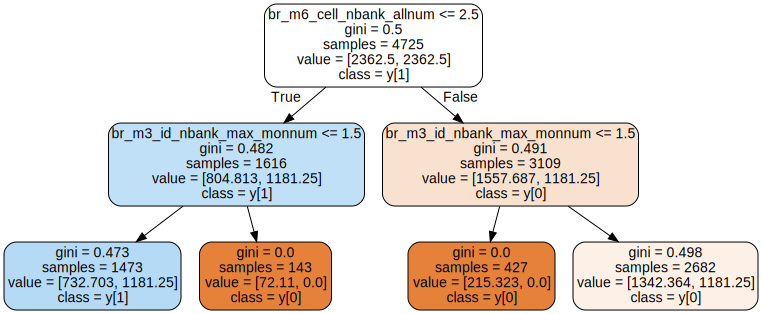

In [27]:
# 1.可视化输出
out_file = os.path.join(IMAGES_PATH, "Credit_tree.dot")
export_graphviz(
        tree_model,
        out_file=out_file, # 输出决策树文档，为制图做准备
        feature_names=cand_features,
        # class_names=['good','bad'],
        class_names=True,
        rounded=True,
        filled=True
    )
Source.from_file(out_file)

In [28]:
# 2.文本化输出
text_representation = export_text(tree_model, feature_names=cand_features)
print(text_representation)

|--- br_m6_cell_nbank_allnum <= 2.50
|   |--- br_m3_id_nbank_max_monnum <= 1.50
|   |   |--- class: 1
|   |--- br_m3_id_nbank_max_monnum >  1.50
|   |   |--- class: 0
|--- br_m6_cell_nbank_allnum >  2.50
|   |--- br_m3_id_nbank_max_monnum <= 1.50
|   |   |--- class: 0
|   |--- br_m3_id_nbank_max_monnum >  1.50
|   |   |--- class: 0



In [29]:
# 3.转为python代码输出
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    print("def predict({}):".format(", ".join(feature_names)))
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature]
    
    def recurse(node, depth):
        """前序遍历树节点"""
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED: # 非叶节点
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else: # 叶节点
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(tree_model, cand_features)

def predict(br_m1_cell_nbank_oth_allnum, br_m6_id_nbank_ca_orgnum, br_als_m6_id_nbank_oth_orgnum, br_m6_cell_nbank_allnum, br_als_m12_id_nbank_p2p_orgnum, br_m3_id_nbank_max_monnum):
  if br_m6_cell_nbank_allnum <= 2.5:
    if br_m3_id_nbank_max_monnum <= 1.5:
      return [[ 732.70277481 1181.25      ]]
    else:  # if br_m3_id_nbank_max_monnum > 1.5
      return [[72.11045891  0.        ]]
  else:  # if br_m6_cell_nbank_allnum > 2.5
    if br_m3_id_nbank_max_monnum <= 1.5:
      return [[215.32283885   0.        ]]
    else:  # if br_m3_id_nbank_max_monnum > 1.5
      return [[1342.36392743 1181.25      ]]
